# **Customer Segmentation Using Clustering**

**By: Rasool Shaikh**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/COLAB/YouseAI_Task/Data/Dataset.csv')
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
data.shape

(8950, 18)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

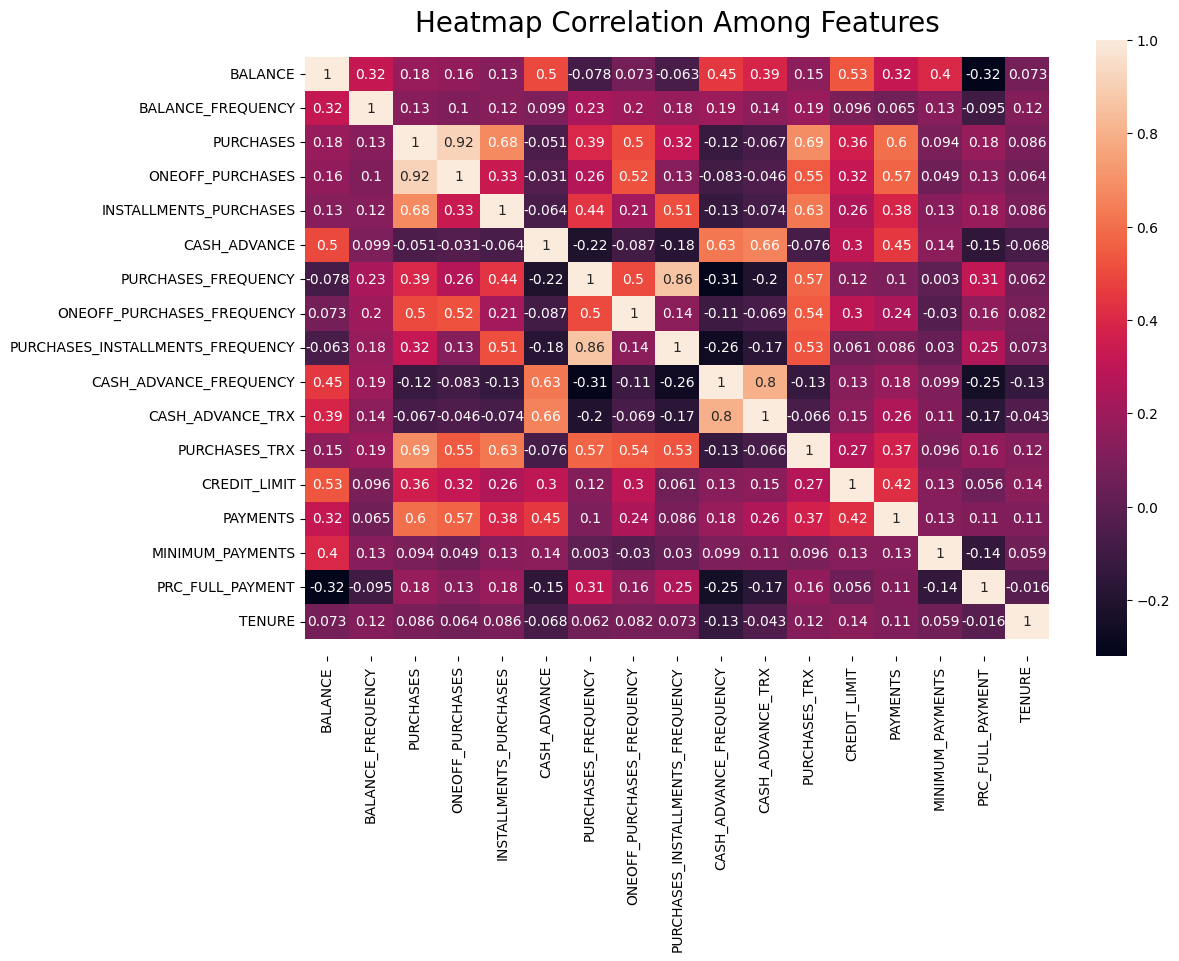

In [6]:
data_feature = data.iloc[:, 1:]

plt.figure(figsize=(12,8))
ax = sns.heatmap(data_feature.corr(), annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Heatmap Correlation Among Features', size=20)
plt.show()

# Data Preprocessing
## Handling Missing Values

In [7]:
data.isnull().sum()

,0
CUST_ID,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


#### There is 1 missing value found in CREDIT_LIMIT column. The credit limit can be retrieved from CASH_ADVANCE.

#### In this case, CASH_ADVANCE is normally 25% of the CREDIT_LIMIT.

In [8]:
data_clean = data.dropna(subset=['CREDIT_LIMIT', 'CASH_ADVANCE']).copy()
data_clean['CASH_ADVANCE_PERCENT'] = (data_clean['CASH_ADVANCE'] / data_clean['CREDIT_LIMIT']) * 100
avg_cash_advance_percent = data_clean['CASH_ADVANCE_PERCENT'].mean()
print(avg_cash_advance_percent)

24.974612598827925


In [9]:
missing_credit_limit_row = data['CREDIT_LIMIT'].isnull()
data.loc[missing_credit_limit_row, 'CREDIT_LIMIT'] = data.loc[missing_credit_limit_row, 'CASH_ADVANCE'] / 0.25


#### There are 313 missing values found in MINIMUM_PAYMENTS column which can be grouped in two categories:

MINIMUM_PAYMENT is empty yet no payment obligation (240 of 313 data)

MINIMUM_PAYMENT is empty with payment obligation (73 of 313 data)

In [10]:
data.loc[(data['MINIMUM_PAYMENTS'].isna()) & (data['PAYMENTS'] == 0), 'MINIMUM_PAYMENTS'] = 0
data.loc[(data['MINIMUM_PAYMENTS'].isna()) & (data['INSTALLMENTS_PURCHASES'] != 0), 'MINIMUM_PAYMENTS'] = data['INSTALLMENTS_PURCHASES']
data.loc[(data['MINIMUM_PAYMENTS'].isna()) & (data['INSTALLMENTS_PURCHASES'] == 0) & (data['CASH_ADVANCE'] != 0), 'MINIMUM_PAYMENTS'] = data['CASH_ADVANCE']
data.loc[(data['MINIMUM_PAYMENTS'].isna()) & (data['INSTALLMENTS_PURCHASES'] == 0) & (data['CASH_ADVANCE'] == 0), 'MINIMUM_PAYMENTS'] = data['PURCHASES'] * 0.10

In [11]:
data.isnull().sum()

,0
CUST_ID,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


# Feature scaling and any necessary feature engineering

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data['BALANCE_scaled'] = scaler.fit_transform(data[['BALANCE']])
data['BALANCE_FREQUENCY_scaled'] = scaler.fit_transform(data[['BALANCE_FREQUENCY']])
data['BALANCE_FREQUENCY_scaled'] = scaler.fit_transform(data[['BALANCE_FREQUENCY']])
data['PURCHASES_scaled'] = scaler.fit_transform(data[['PURCHASES']])
data['ONEOFF_PURCHASES_scaled'] = scaler.fit_transform(data[['ONEOFF_PURCHASES']])
data['INSTALLMENTS_PURCHASES_scaled'] = scaler.fit_transform(data[['INSTALLMENTS_PURCHASES']])
data['CASH_ADVANCE_scaled'] = scaler.fit_transform(data[['CASH_ADVANCE']])
data['PURCHASES_FREQUENCY_scaled'] = scaler.fit_transform(data[['PURCHASES_FREQUENCY']])
data['ONEOFF_PURCHASES_FREQUENCY_scaled'] = scaler.fit_transform(data[['ONEOFF_PURCHASES_FREQUENCY']])
data['PURCHASES_INSTALLMENTS_FREQUENCY_scaled'] = scaler.fit_transform(data[['PURCHASES_INSTALLMENTS_FREQUENCY']])

In [14]:
# ## Engineering Feature
# data['PURCHASE_PER_FREQUENCY'] = data['PURCHASES'] / data['PURCHASES_FREQUENCY']
# data['PAYMENTS_CREDIT_LIMIT_RATIO'] = data['PAYMENTS'] / data['CREDIT_LIMIT']
# data

# Exploratory Data Analysis (EDA)

##What is the distribution of balance across customers?

In [15]:
# Summary Statistics
balance_summary = data['BALANCE'].describe()
balance_summary

,BALANCE
count,8950.000000
mean,1564.474828
std,2081.531879
min,0.000000
25%,128.281915
50%,873.385231
75%,2054.140036
max,19043.138560


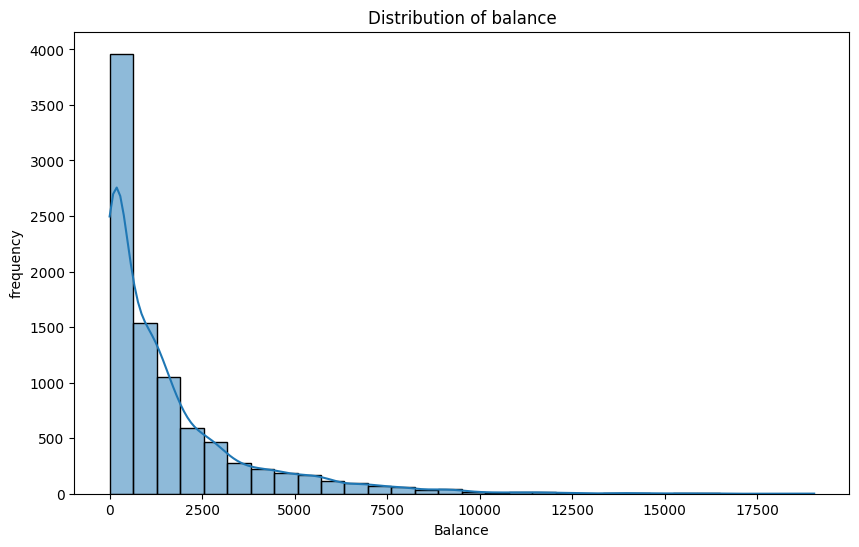

In [16]:
# Plotting Histogram

plt.figure(figsize = (10,6))
sns.histplot(data = data['BALANCE'],bins = 30, kde = True)
plt.xlabel("Balance")
plt.ylabel("frequency")
plt.title("Distribution of balance")
plt.show()

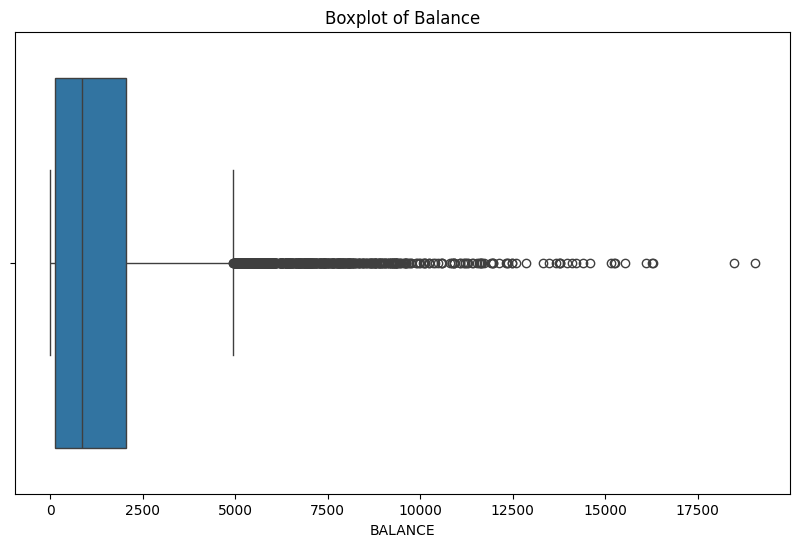

In [17]:
# Plotting Boxplot

plt.figure(figsize = (10,6))
sns.boxplot(x = data['BALANCE'])
plt.title("Boxplot of Balance")
plt.show()

In [18]:
# Skewness and Kurtosis

skewness = data['BALANCE'].skew()
Kurtosis = data['BALANCE'].kurt()
print(f"Skewness : {skewness}")
print(f"Kurtosis : {Kurtosis}")

Skewness : 2.393386042571806
Kurtosis : 7.6747512999062515


In [19]:
# Outliers

Q1 = data['BALANCE'].quantile(0.25)
Q3 = data['BALANCE'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

outliers = data[(data['BALANCE'] < lower) | (data['BALANCE'] > upper)]
print(f"Number of Outliers : {outliers.shape[0]}")

Number of Outliers : 695


##How are purchases (total, one-off, installment) distributed?

In [20]:
# Summary Statistics

purchase_summary = data[['PURCHASES','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES']].describe()
purchase_summary

,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES
count,8950.000000,8950.000000,8950.000000
mean,1003.204834,592.437371,411.067645
std,2136.634782,1659.887917,904.338115
min,0.000000,0.000000,0.000000
25%,39.635000,0.000000,0.000000
50%,361.280000,38.000000,89.000000
75%,1110.130000,577.405000,468.637500
max,49039.570000,40761.250000,22500.000000


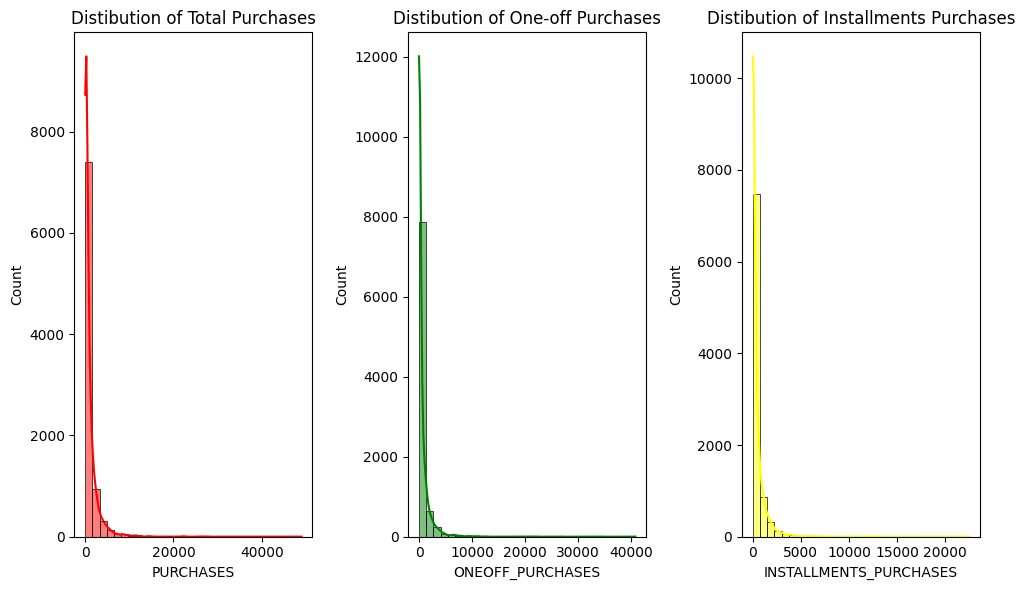

In [21]:
# Plotting Histogram

plt.figure(figsize = (10,6))

plt.subplot(1,3,1)
sns.histplot(data['PURCHASES'],bins = 30, kde = True, color = 'red')
plt.title('Distibution of Total Purchases')

plt.subplot(1,3,2)
sns.histplot(data['ONEOFF_PURCHASES'],bins = 30, kde = True, color = 'green')
plt.title('Distibution of One-off Purchases')

plt.subplot(1,3,3)
sns.histplot(data['INSTALLMENTS_PURCHASES'],bins = 30, kde = True, color = 'yellow')
plt.title('Distibution of Installments Purchases')

plt.tight_layout()
plt.show()

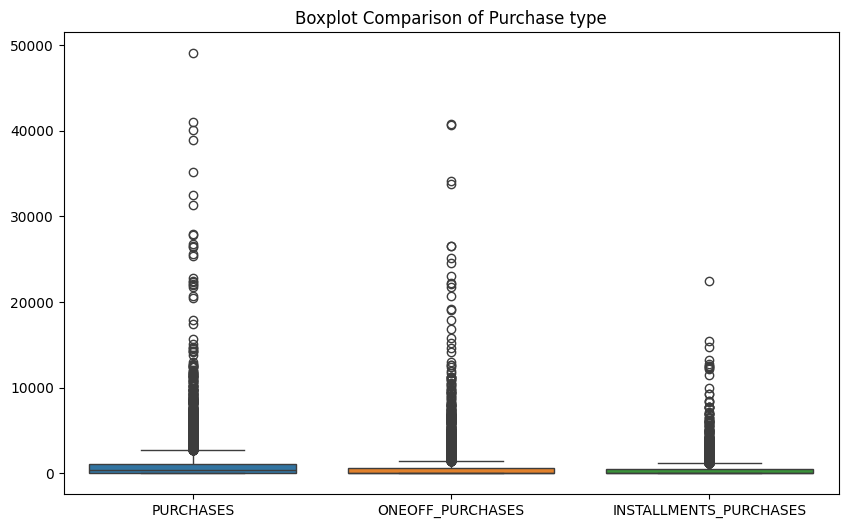

In [22]:
# Plotting Boxplot

plt.figure(figsize = (10,6))

sns.boxplot(data = data[['PURCHASES','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES']])

plt.title("Boxplot Comparison of Purchase type")
plt.show()

In [23]:
correlation_matrix = data[['PURCHASES','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES']].corr()
correlation_matrix

,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES
PURCHASES,1.000000,0.916845,0.679896
ONEOFF_PURCHASES,0.916845,1.000000,0.330622
INSTALLMENTS_PURCHASES,0.679896,0.330622,1.000000


In [24]:
# Skewness and Kurtosis

skewness = data[['PURCHASES','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES']].skew()
Kurtosis = data[['PURCHASES','ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES']].kurt()
print(f"Skewness : {skewness}")
print(f"Kurtosis : {Kurtosis}")

Skewness : PURCHASES                  8.144269
ONEOFF_PURCHASES          10.045083
INSTALLMENTS_PURCHASES     7.299120
dtype: float64
Kurtosis : PURCHASES                 111.388771
ONEOFF_PURCHASES          164.187572
INSTALLMENTS_PURCHASES     96.575178
dtype: float64


##Is there a correlation between credit limit and balance?

In [25]:
credit_balance_summary = data[['CREDIT_LIMIT','BALANCE']].describe()
credit_balance_summary

,CREDIT_LIMIT,BALANCE
count,8950.000000,8950.000000
mean,4494.030787,1564.474828
std,3638.827974,2081.531879
min,50.000000,0.000000
25%,1600.000000,128.281915
50%,3000.000000,873.385231
75%,6500.000000,2054.140036
max,30000.000000,19043.138560


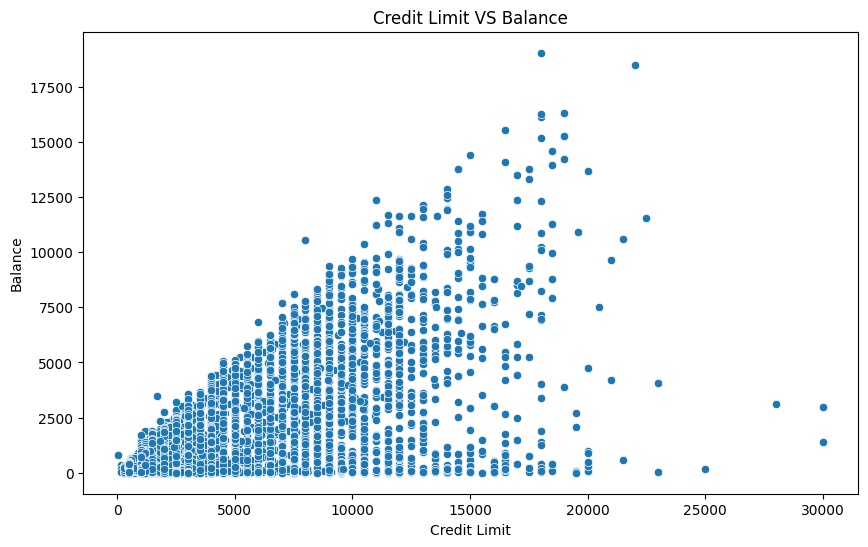

In [26]:
# Plotting Scatterplot

plt.figure(figsize = (10,6))
sns.scatterplot(x = data['CREDIT_LIMIT'], y = data['BALANCE'])
plt.title("Credit Limit VS Balance")
plt.xlabel("Credit Limit")
plt.ylabel("Balance")
plt.show()

In [27]:
Correlation = data[['CREDIT_LIMIT','BALANCE']].corr()
print("Correlation between Credit_Limit and Balance")
print(Correlation)

Correlation between Credit_Limit and Balance
              CREDIT_LIMIT   BALANCE
CREDIT_LIMIT      1.000000  0.531321
BALANCE           0.531321  1.000000


##What is the relationship between customer tenure and balance?

In [28]:
tenure_balance_summary = data[['TENURE','BALANCE']].describe()
tenure_balance_summary

,TENURE,BALANCE
count,8950.000000,8950.000000
mean,11.517318,1564.474828
std,1.338331,2081.531879
min,6.000000,0.000000
25%,12.000000,128.281915
50%,12.000000,873.385231
75%,12.000000,2054.140036
max,12.000000,19043.138560


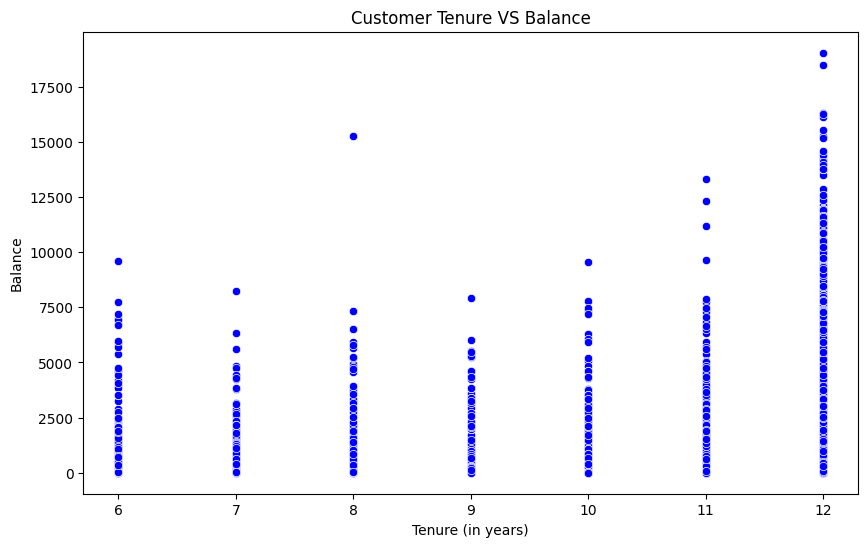

In [29]:
plt.figure(figsize = (10,6))

sns.scatterplot(x = data['TENURE'], y = data['BALANCE'], color = 'blue')
plt.title('Customer Tenure VS Balance')
plt.xlabel("Tenure (in years)")
plt.ylabel("Balance")
plt.show()

In [30]:
correlation = data[['TENURE','BALANCE']].corr()
correlation

,TENURE,BALANCE
TENURE,1.000000,0.072692
BALANCE,0.072692,1.000000


In [31]:
# Group by Tenure and calculate mean balance for each Tenure group
data.groupby('TENURE')['BALANCE'].mean()

,BALANCE
TENURE,
6,1095.890702
7,1003.800362
8,1127.963470
9,1098.752149
10,1251.955773
11,1641.770893
12,1619.158166


## What is the trend of minimum payments in relation to total balance and purchases?

In [32]:
summary = data[['MINIMUM_PAYMENTS','BALANCE','PURCHASES']].describe()
summary

,MINIMUM_PAYMENTS,BALANCE,PURCHASES
count,8950.000000,8950.000000,8950.000000
mean,835.851103,1564.474828,1003.204834
std,2335.482020,2081.531879,2136.634782
min,0.000000,0.000000,0.000000
25%,163.827624,128.281915,39.635000
50%,292.568712,873.385231,361.280000
75%,789.198202,2054.140036,1110.130000
max,76406.207520,19043.138560,49039.570000


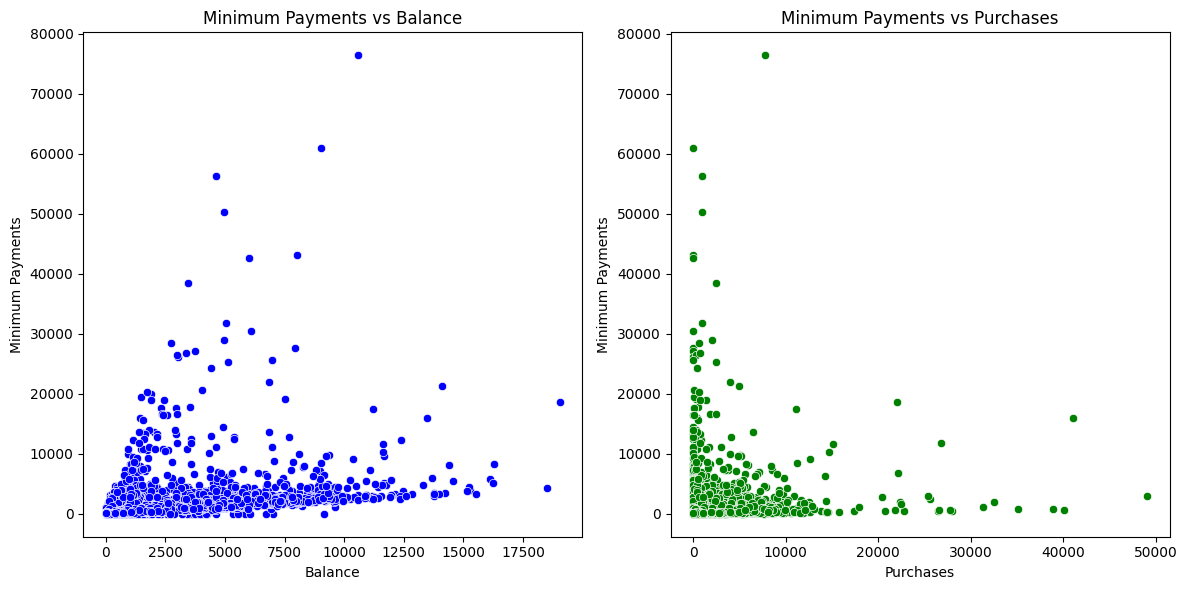

In [33]:
# scatter plot

# Minimum Payments VS Balance

plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
sns.scatterplot(x = data['BALANCE'], y = data['MINIMUM_PAYMENTS'], color = 'blue')
plt.title('Minimum Payments vs Balance')
plt.xlabel('Balance')
plt.ylabel('Minimum Payments')


plt.subplot(1,2,2)
sns.scatterplot(x = data['PURCHASES'], y = data['MINIMUM_PAYMENTS'], color = 'green')
plt.title('Minimum Payments vs Purchases')
plt.xlabel('Purchases')
plt.ylabel('Minimum Payments')

plt.tight_layout()
plt.show()

In [34]:
correlation_matrix = data[['MINIMUM_PAYMENTS', 'BALANCE', 'PURCHASES']].corr()
correlation_matrix

,MINIMUM_PAYMENTS,BALANCE,PURCHASES
MINIMUM_PAYMENTS,1.000000,0.399130,0.096796
BALANCE,0.399130,1.000000,0.181261
PURCHASES,0.096796,0.181261,1.000000


## How frequently do customers make purchases vs. cash advances?

In [35]:
summary = data['PURCHASES_FREQUENCY'].describe()
summary

,PURCHASES_FREQUENCY
count,8950.000000
mean,0.490351
std,0.401371
min,0.000000
25%,0.083333
50%,0.500000
75%,0.916667
max,1.000000


In [36]:
correlation = data[['PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']].corr()
correlation

,PURCHASES_FREQUENCY,CASH_ADVANCE_FREQUENCY
PURCHASES_FREQUENCY,1.000000,-0.308478
CASH_ADVANCE_FREQUENCY,-0.308478,1.000000


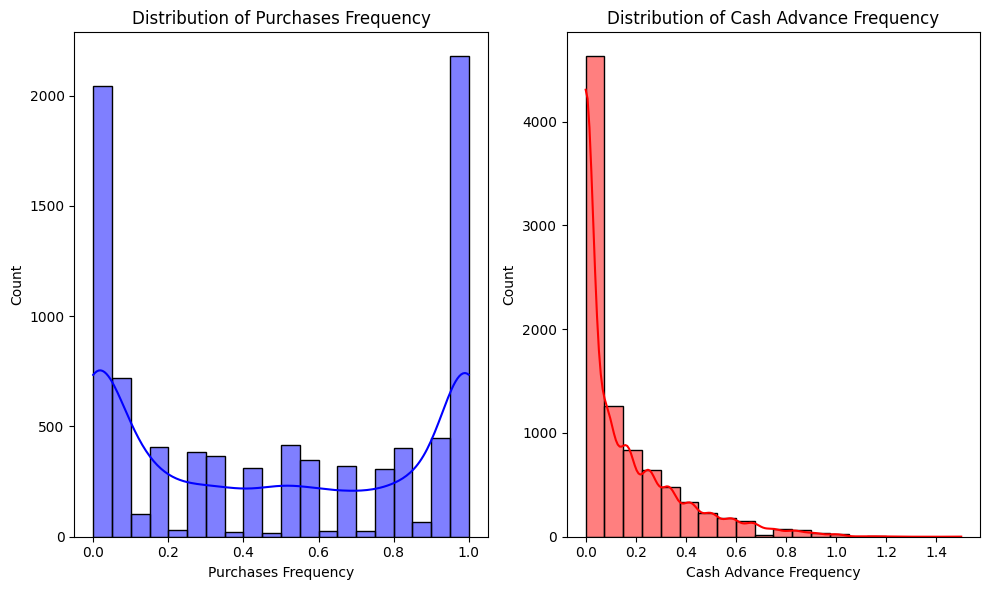

In [37]:
plt.figure(figsize=(10, 6))

# Histogram for Purchases Frequency
plt.subplot(1, 2, 1)
sns.histplot(data['PURCHASES_FREQUENCY'], bins = 20, kde = True, color = 'blue')
plt.title('Distribution of Purchases Frequency')
plt.xlabel('Purchases Frequency')

# Histogram for Cash Advance Frequency
plt.subplot(1, 2, 2)
sns.histplot(data['CASH_ADVANCE_FREQUENCY'], bins = 20, kde = True, color = 'red')
plt.title('Distribution of Cash Advance Frequency')
plt.xlabel('Cash Advance Frequency')

plt.tight_layout()
plt.show()

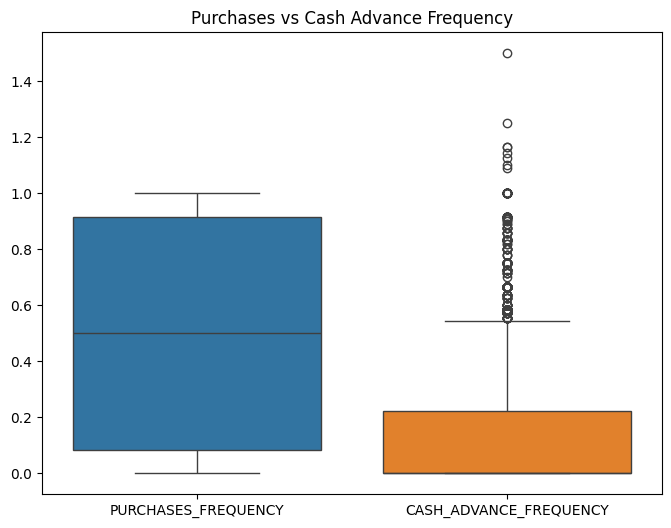

In [38]:
# Box plot to compare Purchases Frequency vs Cash Advance Frequency
plt.figure(figsize = (8, 6))
sns.boxplot(data = data[['PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']])
plt.title('Purchases vs Cash Advance Frequency')
plt.show()

##What is the percentage of customers who make full payments?

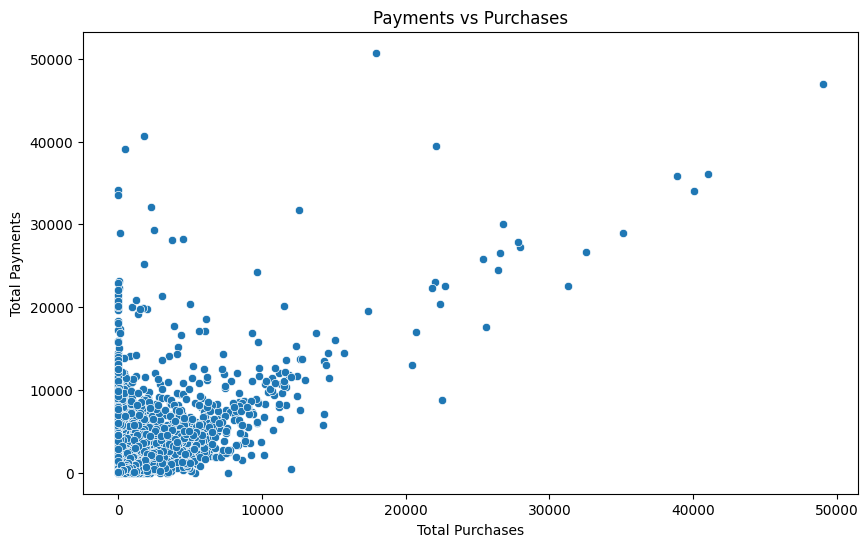

In [39]:
plt.figure(figsize=(10,6))
sns.scatterplot(x = data['PURCHASES'], y = data['PAYMENTS'])
plt.title('Payments vs Purchases')
plt.xlabel('Total Purchases')
plt.ylabel('Total Payments')
plt.show()

In [40]:
# data['PAYMENTS_TO_PURCHASES_RATIO'] = data['PAYMENTS'] / data['PURCHASES']

# low_payment_customers = data[data['PAYMENTS_TO_PURCHASES_RATIO'] < 0.8]
# high_payment_customers = data[data['PAYMENTS_TO_PURCHASES_RATIO'] > 1.2]
# low_payment_customers[['CUST_ID', 'PURCHASES', 'PAYMENTS', 'PAYMENTS_TO_PURCHASES_RATIO']].head()

In [41]:
# high_payment_customers[['CUST_ID', 'PURCHASES', 'PAYMENTS', 'PAYMENTS_TO_PURCHASES_RATIO']].head()

## Which customers are most likely to rely on cash advances?

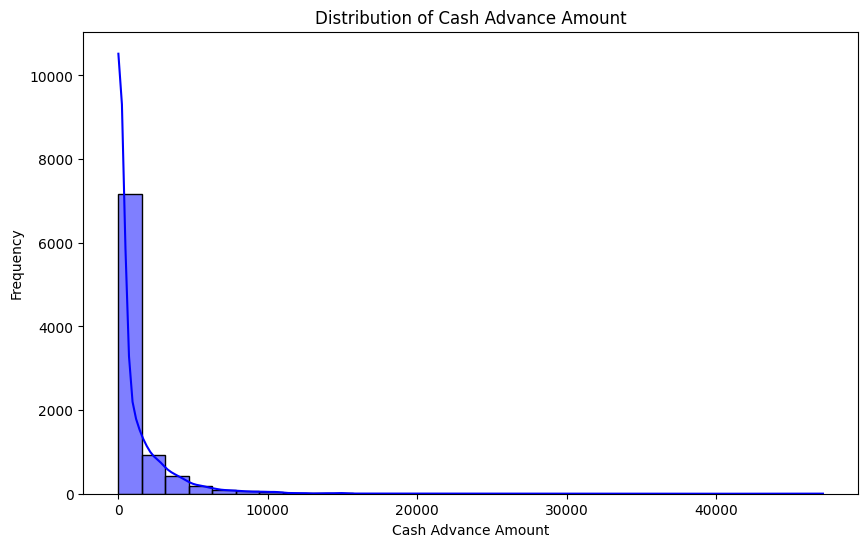

In [42]:
plt.figure(figsize = (10, 6))
sns.histplot(data['CASH_ADVANCE'], kde = True, bins = 30, color = 'blue')
plt.title('Distribution of Cash Advance Amount')
plt.xlabel('Cash Advance Amount')
plt.ylabel('Frequency')
plt.show()

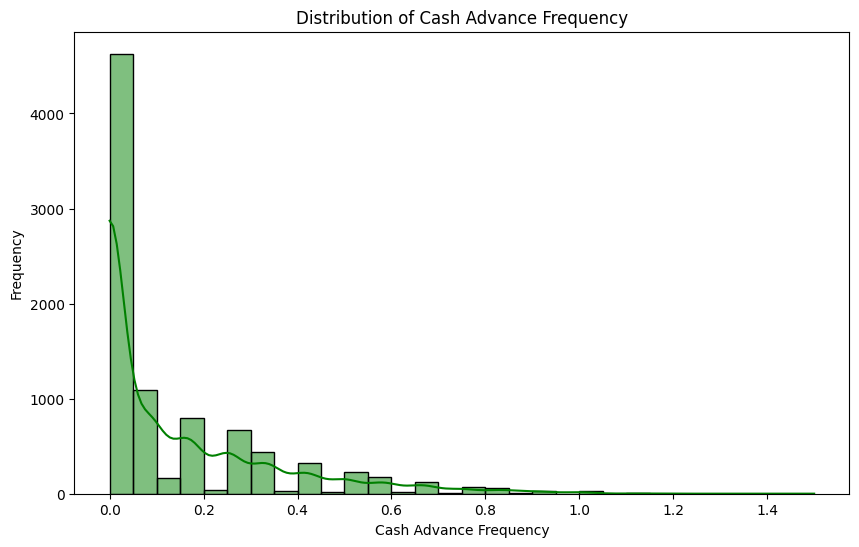

In [43]:
plt.figure(figsize = (10, 6))
sns.histplot(data['CASH_ADVANCE_FREQUENCY'], kde = True, bins = 30, color = 'green')
plt.title('Distribution of Cash Advance Frequency')
plt.xlabel('Cash Advance Frequency')
plt.ylabel('Frequency')
plt.show()

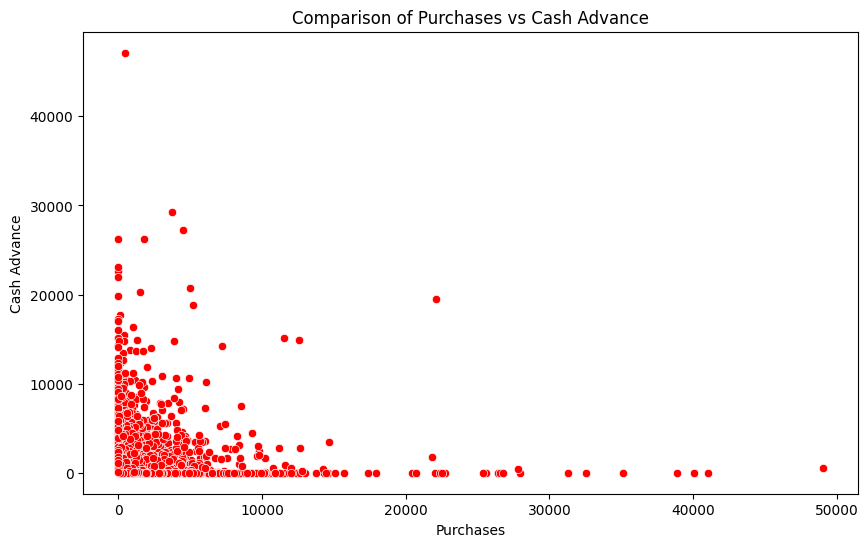

In [44]:
plt.figure(figsize = (10, 6))
sns.scatterplot(x = data['PURCHASES'], y = data['CASH_ADVANCE'], color = 'red')
plt.title('Comparison of Purchases vs Cash Advance')
plt.xlabel('Purchases')
plt.ylabel('Cash Advance')
plt.show()

In [45]:
high_cash_advancers = data[data['CASH_ADVANCE'] > data['CASH_ADVANCE'].quantile(0.75)]
high_cash_advancers[['CUST_ID', 'CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY', 'PURCHASES', 'CREDIT_LIMIT', 'BALANCE']].head()

,CUST_ID,CASH_ADVANCE,CASH_ADVANCE_FREQUENCY,PURCHASES,CREDIT_LIMIT,BALANCE
1,C10002,6442.945483,0.250000,0.00,7000.0,3202.467416
15,C10016,2301.491267,0.166667,1611.70,8000.0,6886.213231
16,C10017,2784.274703,0.250000,0.00,3000.0,2072.074354
23,C10024,7974.415626,0.333333,4248.35,9000.0,3800.151377
28,C10029,2236.145259,0.833333,387.05,10500.0,7152.864372


## Are there any significant outliers in the credit limit or balance columns?

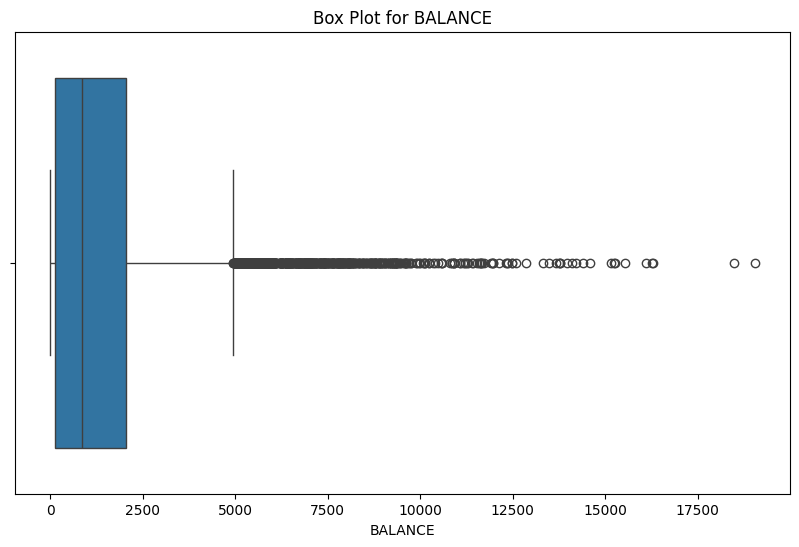

In [46]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = data['BALANCE'])
plt.title('Box Plot for BALANCE')
plt.show()

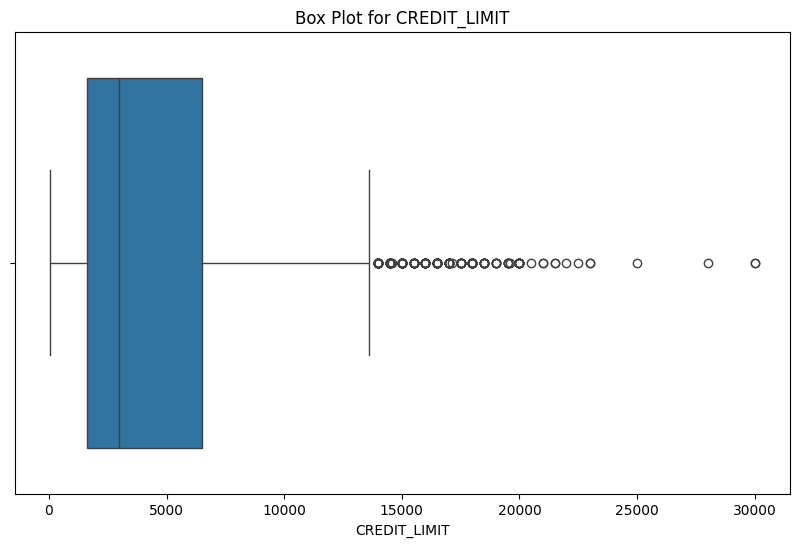

In [47]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = data['CREDIT_LIMIT'])
plt.title('Box Plot for CREDIT_LIMIT')
plt.show()

In [49]:
Q1_bl = data['BALANCE'].quantile(0.25)
Q3_bl = data['BALANCE'].quantile(0.75)
IQR = Q3_bl - Q1_bl
balance_outliers = data[(data['BALANCE'] < (Q1_bl - 1.5 * IQR)) | (data['BALANCE'] > (Q3_bl + 1.5 * IQR))]

print(f"Number of outliers in BALANCE: {balance_outliers.shape[0]}")


Number of outliers in BALANCE: 695


In [50]:
Q1_cl = data['CREDIT_LIMIT'].quantile(0.25)
Q3_cl = data['CREDIT_LIMIT'].quantile(0.75)
IQR_cl = Q3_cl - Q1_cl
credit_limit_outliers = data[(data['CREDIT_LIMIT'] < (Q1_cl - 1.5 * IQR_cl)) | (data['CREDIT_LIMIT'] > (Q3_cl + 1.5 * IQR_cl))]
print(f"Number of outliers in CREDIT_LIMIT: {credit_limit_outliers.shape[0]}")

Number of outliers in CREDIT_LIMIT: 248


# Clustering

In [51]:
data.columns

Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE', 'BALANCE_scaled',
       'BALANCE_FREQUENCY_scaled', 'PURCHASES_scaled',
       'ONEOFF_PURCHASES_scaled', 'INSTALLMENTS_PURCHASES_scaled',
       'CASH_ADVANCE_scaled', 'PURCHASES_FREQUENCY_scaled',
       'ONEOFF_PURCHASES_FREQUENCY_scaled',
       'PURCHASES_INSTALLMENTS_FREQUENCY_scaled'],
      dtype='object')

In [52]:
data.isnull().sum()

,0
CUST_ID,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0


Drop the PURCHASES column as the data contained in this column are also present in other columns.

In [53]:
df_ready = data.drop(['PURCHASES','CUST_ID'], axis=1)
df_ready.head()

,BALANCE,BALANCE_FREQUENCY,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,...,TENURE,BALANCE_scaled,BALANCE_FREQUENCY_scaled,PURCHASES_scaled,ONEOFF_PURCHASES_scaled,INSTALLMENTS_PURCHASES_scaled,CASH_ADVANCE_scaled,PURCHASES_FREQUENCY_scaled,ONEOFF_PURCHASES_FREQUENCY_scaled,PURCHASES_INSTALLMENTS_FREQUENCY_scaled
0,40.900749,0.818182,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,...,12,-0.731989,-0.249434,-0.424900,-0.356934,-0.349079,-0.466786,-0.806490,-0.678661,-0.707313
1,3202.467416,0.909091,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,...,12,0.786961,0.134325,-0.469552,-0.356934,-0.454576,2.605605,-1.221758,-0.678661,-0.916995
2,2495.148862,1.000000,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,...,12,0.447135,0.518084,-0.107668,0.108889,-0.454576,-0.466786,1.269843,2.673451,-0.916995
3,1666.670542,0.636364,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,...,12,0.049099,-1.016953,0.232058,0.546189,-0.454576,-0.368653,-1.014125,-0.399319,-0.916995
4,817.714335,1.000000,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,...,12,-0.358775,0.518084,-0.462063,-0.347294,-0.454576,-0.466786,-1.014125,-0.399319,-0.916995


# K Means Clustering

Without PCA

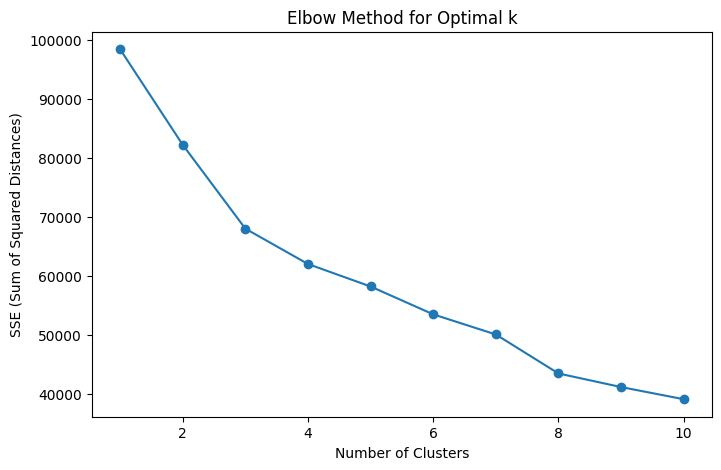

Cluster centers:
 [[ 1.90184074  1.68975383  0.8655468   1.10011896  1.29824348 -0.20105056
   0.02996053  1.40389998 -0.17031175 -0.3804149   0.04101506]
 [-0.20632561 -0.10961081 -0.11816382 -0.25931789 -0.34528572 -0.82170419
  -0.38081773  0.0563859  -0.7398909  -0.35433499 -0.07110026]
 [-0.33305556 -0.37672718 -0.12497451 -0.03919099 -0.00319663  0.96005672
   0.40872602 -0.47466827  0.86131554  0.50036911  0.06589449]]

Cluster labels assigned:
 Cluster
1    4108
2    3744
0    1098
Name: count, dtype: int64


In [54]:
columns_for_clustering = ['BALANCE', 'CASH_ADVANCE', 'MINIMUM_PAYMENTS', 'PAYMENTS',
                         'CREDIT_LIMIT', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
                         'CASH_ADVANCE_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']


scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_ready[columns_for_clustering])

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

print("Cluster centers:\n", kmeans.cluster_centers_)
print("\nCluster labels assigned:\n", data['Cluster'].value_counts())

With PCA

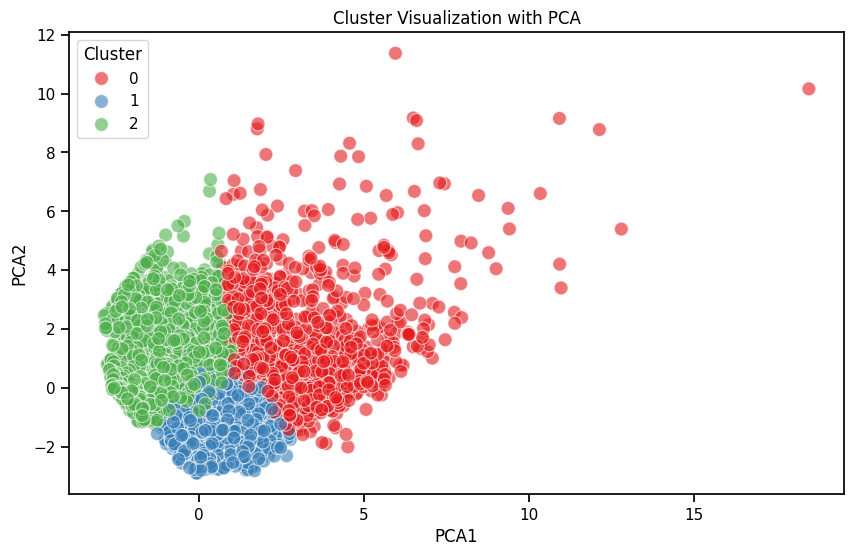

In [74]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

df_pca = pd.DataFrame(data=pca_data, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = data['Cluster']

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_pca, palette='Set1', s=100, alpha=0.6)
plt.title('Cluster Visualization with PCA')
plt.show()


In [75]:
silhouette_avg_before = silhouette_score(scaled_data, data['Cluster'])
print("Silhouette Score Before PCA: ", silhouette_avg_before)

silhouette_avg_after_pca = silhouette_score(pca_data, data['Cluster'])
print("Silhouette Score After PCA: ", silhouette_avg_after_pca)

Silhouette Score Before PCA:  0.23398463075806028
Silhouette Score After PCA:  0.44449209220599156


#### Impact Assessment of PCA on Clustering Performance

In the clustering analysis, we used KMeans clustering both before and after applying **Principal Component Analysis (PCA)**. The purpose of this assessment is to understand the effect of dimensionality reduction on the clustering performance, which is evaluated using the **silhouette score**.

1. **Silhouette Score Before PCA**:  
   - **Score**: 0.2339
   - This score reflects the clustering quality when all original features were used without dimensionality reduction. A silhouette score of 0.2339 indicates that the clusters were moderately well-defined but not highly distinct. There is likely some overlap between clusters, and certain points might be closer to cluster boundaries, reducing the separation between them.

2. **Silhouette Score After PCA**:  
   - **Score**: 0.4444
   - After applying PCA to reduce the dimensionality of the dataset, the silhouette score increased to 0.4444. This shows a significant improvement in the clustering quality. The higher score indicates that the clusters became more distinct, and the data points are better separated. PCA likely helped by removing noise or irrelevant dimensions, enabling KMeans to find more meaningful clusters in the reduced space.


### Conclusion:
Applying PCA before clustering significantly improved the clustering quality as evidenced by the higher silhouette score. This suggests that in cases where many features are involved, applying dimensionality reduction techniques like PCA can enhance the performance of clustering algorithms like KMeans by making the underlying data structure clearer.

In [76]:
pca = PCA(random_state=42).fit(df_ready)
pca_data = pca.transform(df_ready)
pca_labels = ['PC' + str(component) for component in range(1,len(pca.components_)+1)]
pca_df = pd.DataFrame(pca_data, columns=pca_labels)
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27
0,-4280.932640,641.164101,-157.026433,-13.944166,-40.115143,12.427759,-65.615812,-4.525418,-1.319829,0.555293,...,0.000217,1.080540e-10,-7.877032e-13,4.712064e-13,-1.327938e-12,-1.426748e-12,1.313133e-08,-1.687462e-09,-2.768101e-09,-5.856177e-10
1,4796.187890,1260.244950,1099.640222,4148.250613,-1052.387651,927.768468,185.121862,-3.388628,-10.595418,0.825585,...,-0.000002,-6.614959e-11,4.824474e-13,-2.875547e-13,8.061329e-13,8.666401e-13,-1.232189e-10,1.031205e-09,1.164873e-09,4.334899e-10
2,1712.464859,-2889.314613,-445.793594,-566.202746,529.526349,7.123723,-509.317788,-0.075018,-1.226236,0.513005,...,-0.000037,2.825684e-10,-2.049583e-12,1.222578e-12,-3.437362e-12,-3.679890e-12,-2.299664e-09,-4.363692e-09,-4.818012e-09,-9.050316e-10
3,1235.431014,-3112.649114,-1250.319600,-543.016426,449.768291,1011.085223,-198.893784,-15.176325,-0.293694,0.225419,...,0.000033,1.435400e-10,-1.050049e-12,6.261033e-13,-1.756595e-12,-1.892819e-12,1.993429e-09,-2.242519e-09,-3.887231e-09,-1.435332e-09
4,-3643.353536,813.699624,85.545248,50.438273,422.717343,-332.114896,-308.061828,-4.549605,-1.603466,0.597045,...,0.000104,8.436746e-11,-6.206147e-13,3.708076e-13,-1.050937e-12,-1.119688e-12,6.267691e-09,-1.310507e-09,-2.707780e-09,-2.407016e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,-4225.670166,736.890537,-270.171306,-19.311447,-37.732747,-90.454010,96.785238,-3.111621,-1.348612,-4.847898,...,0.000221,-4.003817e-10,2.934708e-12,-1.747255e-12,4.898304e-12,5.282358e-12,1.330528e-08,6.209348e-09,1.112689e-08,3.609582e-09
8946,-4214.537389,720.138283,-58.589666,-131.667185,-113.102805,-45.144675,109.754298,-3.259127,-1.333985,-4.844414,...,0.000254,-1.193370e-10,8.826273e-13,-5.246290e-13,1.470601e-12,1.584816e-12,1.533284e-08,1.840786e-09,4.071540e-09,1.813563e-09
8947,-4349.355782,553.299843,-186.266017,11.633418,-18.871049,40.186260,7.636471,-2.214519,-1.380337,-5.035206,...,0.000208,-1.749668e-10,1.287193e-12,-7.649575e-13,2.141398e-12,2.314426e-12,1.254229e-08,2.705798e-09,5.298934e-09,1.734046e-09
8948,-4740.187164,827.076843,-84.821921,114.028946,89.594298,86.219355,-99.499124,-5.182908,0.492130,-5.277525,...,0.000111,5.380763e-11,-3.969602e-13,2.407310e-13,-6.855627e-13,-7.250589e-13,6.725073e-09,-8.378716e-10,-2.458615e-09,-3.521093e-10


In [58]:
explained_var_ratio_per_PCA = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
explained_var_ratio_per_PCA_df = pd.DataFrame(pca.explained_variance_ratio_ * 100, index= pca_labels)
explained_var_ratio_per_PCA_df.head()

,0
PC1,49.334828
PC2,16.366221
PC3,15.185412
PC4,10.360267
PC5,4.646781


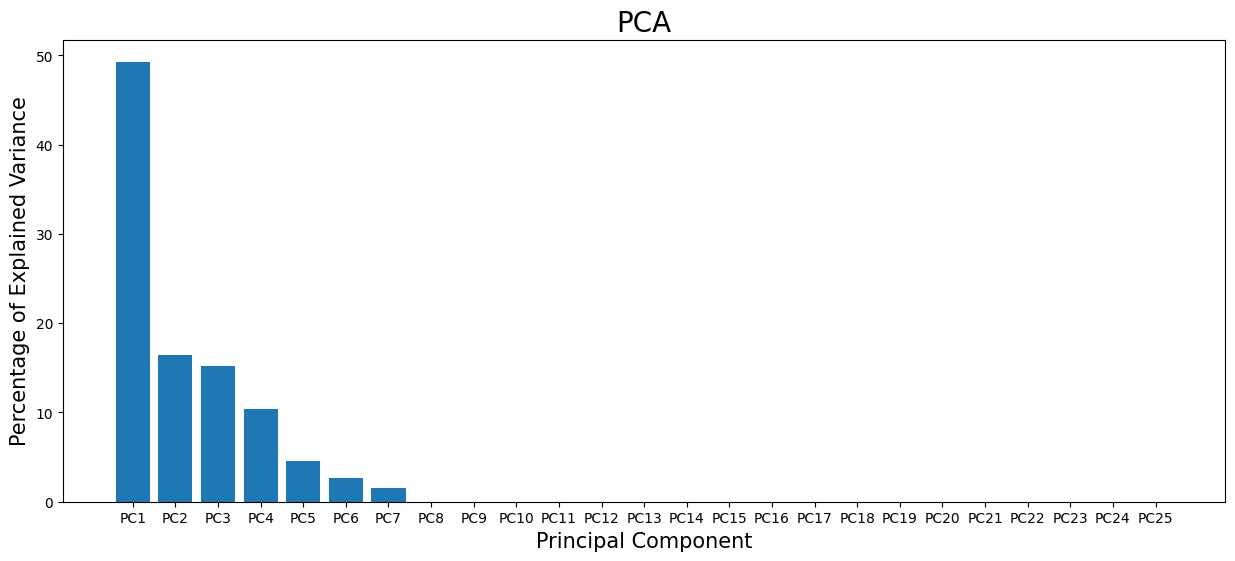

In [59]:
fig = plt.figure(figsize=(15,6))
plt.bar(x=range(1, len(explained_var_ratio_per_PCA)+1), height=explained_var_ratio_per_PCA, tick_label=pca_labels)
plt.ylabel('Percentage of Explained Variance', fontsize=15)
plt.xlabel('Principal Component', fontsize=15)
plt.title('PCA', fontsize=20)
plt.show()

In [60]:
print(f"Total variation explained by PC1 dan PC2 is :{pca.explained_variance_ratio_[:2].sum()*100}")


Total variation explained by PC1 dan PC2 is :65.70104917394526


## DBSCAN

Without PCA

cluster
 0    8858
-1      67
 2       9
 1       6
 3       5
 4       5
Name: count, dtype: int64
Silhouette Score: 0.7363869308839708


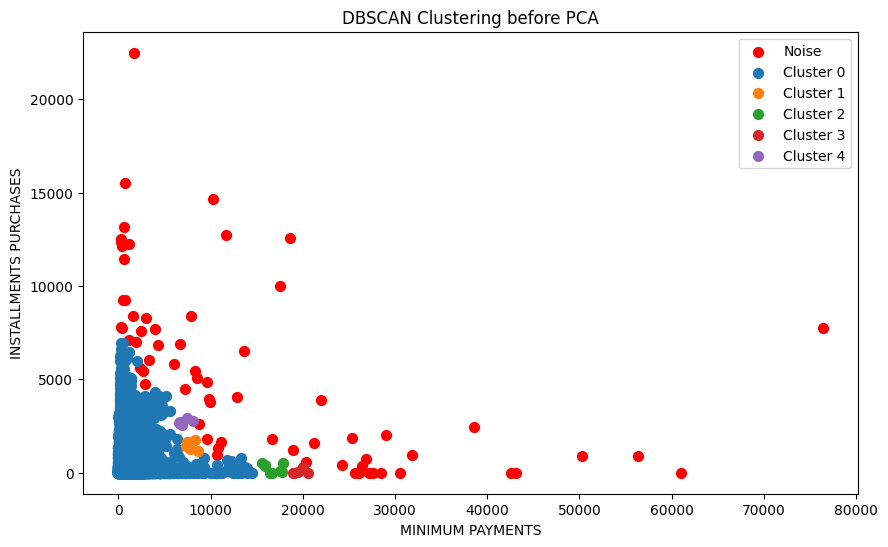

In [65]:
features = ['MINIMUM_PAYMENTS', 'INSTALLMENTS_PURCHASES']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_ready[features])

dbscan = DBSCAN(eps=0.5, min_samples=5)
df_ready['cluster'] = dbscan.fit_predict(scaled_data)


print(df_ready['cluster'].value_counts())


if len(np.unique(df_ready['cluster'])) > 1 and (df_ready['cluster'] != -1).sum() > 0:
    silhouette_avg = silhouette_score(scaled_data[df_ready['cluster'] != -1], df_ready['cluster'][df_ready['cluster'] != -1])
    print(f'Silhouette Score: {silhouette_avg}')
else:
    print('Silhouette Score cannot be computed due to insufficient clusters or too much noise.')


plt.figure(figsize=(10, 6))

for cluster_label in np.unique(df_ready['cluster']):
    cluster_data = df_ready[df_ready['cluster'] == cluster_label]
    if cluster_label == -1:
        plt.scatter(cluster_data['MINIMUM_PAYMENTS'], cluster_data['INSTALLMENTS_PURCHASES'],
                    label='Noise', color='red', s=50)
    else:
        plt.scatter(cluster_data['MINIMUM_PAYMENTS'], cluster_data['INSTALLMENTS_PURCHASES'],
                    label=f'Cluster {cluster_label}', s=50)

plt.title('DBSCAN Clustering before PCA')
plt.xlabel('MINIMUM PAYMENTS')
plt.ylabel('INSTALLMENTS PURCHASES')
plt.legend()
plt.show()

With PCA

cluster_pca
 0    8858
-1      67
 2       9
 1       6
 3       5
 4       5
Name: count, dtype: int64
Silhouette Score with PCA: 0.7363869308846954


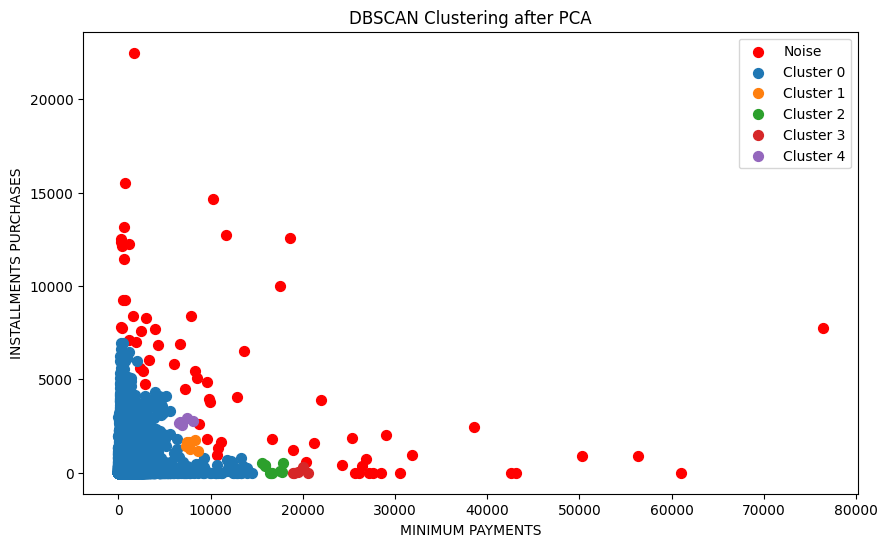

In [66]:
features = ['MINIMUM_PAYMENTS', 'INSTALLMENTS_PURCHASES']


scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_ready[features])

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

dbscan_pca = DBSCAN(eps=0.5, min_samples=5)
df_ready['cluster_pca'] = dbscan_pca.fit_predict(pca_data)

print(df_ready['cluster_pca'].value_counts())

if len(np.unique(df_ready['cluster_pca'])) > 1 and (df_ready['cluster_pca'] != -1).sum() > 0:
    silhouette_avg_pca = silhouette_score(pca_data[df_ready['cluster_pca'] != -1],
                                          df_ready['cluster_pca'][df_ready['cluster_pca'] != -1])
    print(f"Silhouette Score with PCA: {silhouette_avg_pca}")
else:
    print('Silhouette Score cannot be computed after PCA due to insufficient clusters or too much noise.')

# Plotting the clusters after PCA
plt.figure(figsize=(10, 6))

for cluster_label in np.unique(df_ready['cluster_pca']):
    cluster_data = df_ready[df_ready['cluster_pca'] == cluster_label]
    if cluster_label == -1:
        plt.scatter(cluster_data[features[0]], cluster_data[features[1]],
                    label='Noise', color='red', s=50)
    else:
        plt.scatter(cluster_data[features[0]], cluster_data[features[1]],
                    label=f'Cluster {cluster_label}', s=50)

plt.title('DBSCAN Clustering after PCA')
plt.xlabel('MINIMUM PAYMENTS')
plt.ylabel('INSTALLMENTS PURCHASES')
plt.legend()
plt.show()


The silhouette score for clustering:

- **Before PCA**: 0.737
- **After PCA**: 0.737

In this case, applying PCA did not significantly impact the clustering performance, as the silhouette score remained the same before and after PCA. This indicates that the dimensionality reduction through PCA did not improve or worsen the separation of clusters based on the DBSCAN algorithm for the given dataset.

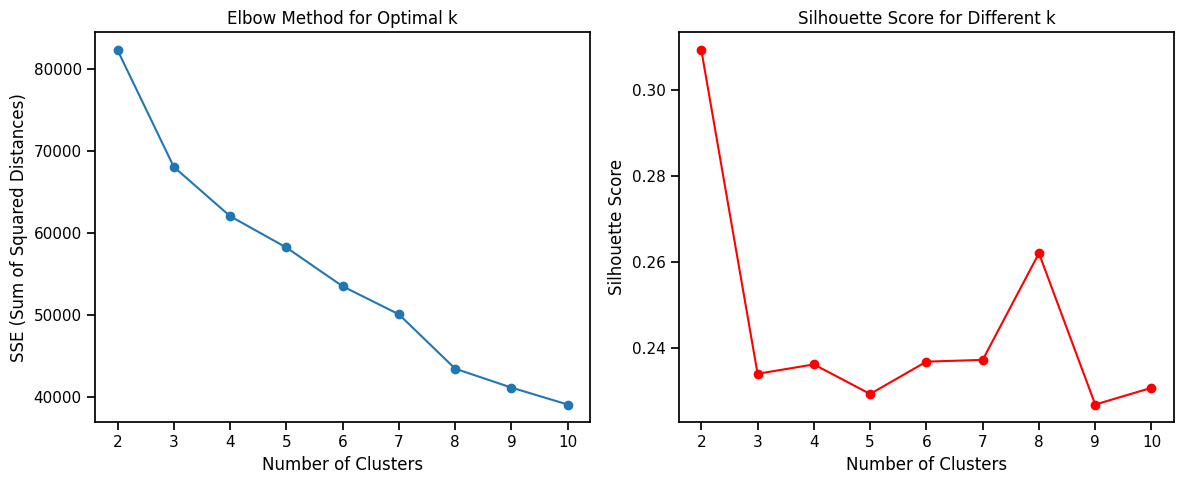

In [77]:
columns_for_clustering = ['BALANCE', 'CASH_ADVANCE', 'MINIMUM_PAYMENTS', 'PAYMENTS',
                         'CREDIT_LIMIT', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
                         'CASH_ADVANCE_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'PRC_FULL_PAYMENT', 'TENURE']


scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_ready[columns_for_clustering])


sse = []
silhouette_scores = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    sse.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Plotting the Elbow Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')

# Plotting the Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')

plt.tight_layout()
plt.show()

# Optimal value from the graph would be 3

# Cluster profiling and marketing recommendations

## Detailed descriptions of each segment.

In [69]:
cluster_summary = data.groupby('Cluster').agg(
    BALANCE=('BALANCE', 'mean'),
    PURCHASES=('PURCHASES', 'mean'),
    ONEOFF_PURCHASES=('ONEOFF_PURCHASES', 'mean'),
    INSTALLMENTS_PURCHASES=('INSTALLMENTS_PURCHASES', 'mean'),
    CASH_ADVANCE=('CASH_ADVANCE', 'mean'),
    CREDIT_LIMIT=('CREDIT_LIMIT', 'mean'),
    PAYMENTS=('PAYMENTS', 'mean'),
    MINIMUM_PAYMENTS=('MINIMUM_PAYMENTS', 'mean'),
    TENURE=('TENURE', 'mean'),
    COUNT=('Cluster', 'size')
).reset_index()

cluster_summary


,Cluster,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,TENURE,COUNT
0,0,5530.620249,1712.273689,1100.671029,611.683670,4529.668707,9227.098857,4919.148146,2858.244862,11.571038,1098
1,1,1134.358537,285.121565,227.327512,58.128325,748.722990,3237.492067,982.738671,560.270921,11.422590,4108
2,2,873.259563,1583.153675,843.994728,739.486002,190.055067,4484.669761,1622.148064,545.117941,11.605502,3744


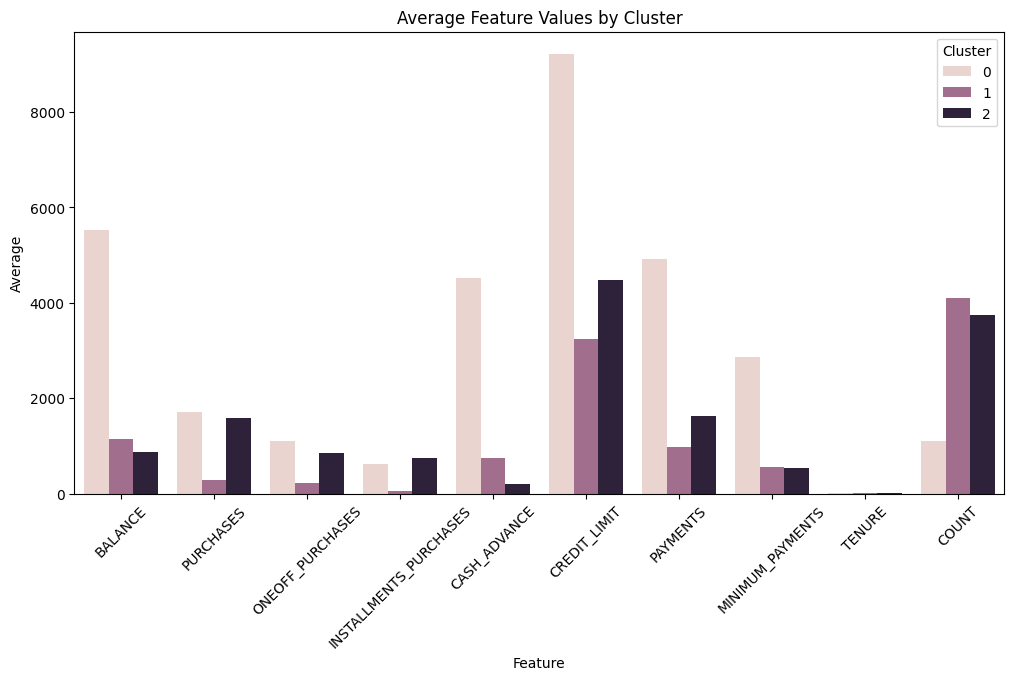

In [70]:
melted_summary = cluster_summary.melt(id_vars='Cluster', var_name='Feature', value_name='Average')

plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Average', hue='Cluster', data=melted_summary)
plt.xticks(rotation=45)
plt.title('Average Feature Values by Cluster')
plt.show()

### Cluster 0 has a high average BALANCE and PURCHASES, indicating these customers are high spenders.
### Cluster 1 has low average CASH_ADVANCE and moderate CREDIT_LIMIT, suggesting they are cautious users.

##  Marketing Strategies

### High Spenders (e.g., Cluster 0):

##### Description: Customers with high balances and frequent purchases.
##### Strategy:Encourage customers in these clusters with credit limit increases and rewards for good payment behavior.


### Moderate Users (e.g., Cluster 1):

##### Description: Average balances and purchases; engaged but not high spenders.
##### Strategy: Encourage them to use products more frequently with targeted promotions and rewards.


### Budget-Conscious Customers (e.g., Cluster 2):

##### Description: Low balances and low purchases; likely to be sensitive to spending.
##### Strategy: Provide financial education, budgeting tools, and discounts on essential services.